In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web #package and modules for importing data
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
from utils.utils import get_data_frame_for_symbols, get_data_frame, spy_data_frame, spx_data_frame
from utils.get_stats import get_stocks_stas, compute_daily_return
from utils.bollinger_band import bollinger_bands, rolling_mean, rolling_std, plot_bollinger_band, candlestick
import math
import scipy.optimize as spo

In [2]:
def calculate_portforlio_value(start_value, start, end, symbols, allocations):

    data_frame = get_data_frame_for_symbols(symbols, start, end)
    data_frame.drop("SPY", inplace = True, axis = 1)
    normalized = data_frame / data_frame.ix[0]
    allocated = normalized * allocations
    position_values = start_value * allocated
    portfolio_value = position_values.sum(axis=1)

    return portfolio_value

def assess_portfolio(start_value, start_date, end_date,
                     symbols, allocations, risk_free_return=0.0,
                     sampling_frequency=252):

    portfolio_value = calculate_portforlio_value(1000000, start_date, end_date, symbols, allocations)
    avg_daily_return, std_daily_returns, beta, alpha, momentum, infor_ratio, sharpe_ratio = get_stocks_stas(portfolio_value, start_date, end_date, sampling_frequency, risk_free_return)

    return avg_daily_return, std_daily_returns,beta, alpha, momentum, infor_ratio, sharpe_ratio


## Create our porfolio

#### Notre portefeuille comprends 14 stocks dans l'indice S&P500.
#### Starting date: 01/01/2017 => End date: 01/09/2017

In [3]:
start_date = datetime.datetime(2016, 1, 1)
end_date = datetime.datetime(2017, 9, 1)

allocations = [ 0.2, 0.1, 0.1, 0.1, 0.1, 0, 0.1, 0, 0, 0.1 , 0, 0.1, 0.1, 0 ]
start_value = 1000000

list_stocks = ['AAPL','GOOG','AMZN','AXP','BAC','BA','KO','FB','IBM','GE', 'GS','HP', 'XOM', 'F']

## La valeur de portefeuille en fonction du temps

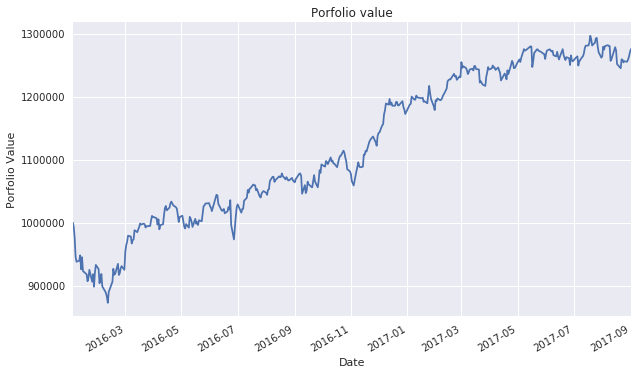

In [4]:
calculate_portforlio_value(start_value, start_date, end_date, list_stocks, allocations).plot(title = "Porfolio value", figsize = (10,6))
plt.xlabel("Date")
plt.ylabel("Porfolio Value")

In [5]:
portfolio_value = calculate_portforlio_value(start_value, start_date, end_date, list_stocks, allocations)
spx_value = spx_data_frame(start_date, end_date)

In [6]:
portfolio_value_return = portfolio_value/portfolio_value[0]
spx_value_return = spx_value/spx_value.ix[0]

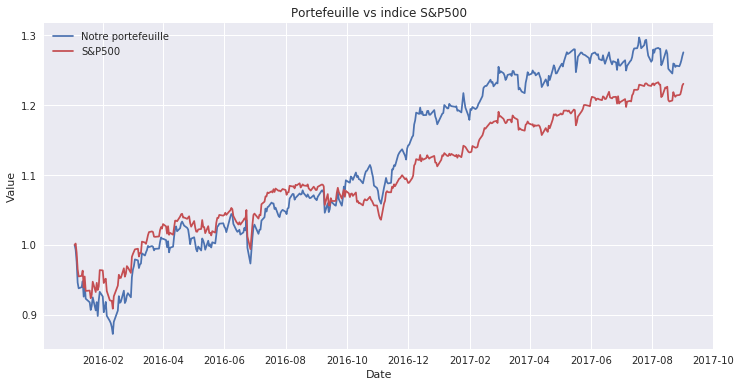

In [7]:
plt.figure(figsize=(12,6))
plt.plot(portfolio_value_return, 'b', label = "Notre portefeuille")
plt.plot(spx_value_return, 'r', label = 'S&P500')
plt.title("Portefeuille vs indice S&P500")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(loc = 'upper left')

## Ratios de notre portfeuille

In [8]:
assess_pf = pd.DataFrame(list(assess_portfolio(start_value, start_date, end_date, list_stocks , allocations))).T

In [9]:
assess_pf.columns = ["avg_daily_return", "std_daily_return", "beta", "alpha", "momentum", "infor_ratio", "sharpe_ratio"]

In [10]:
assess_pf.rename(index = {0: "porfolio"})

,avg_daily_return,std_daily_return,beta,alpha,momentum,infor_ratio,sharpe_ratio
porfolio,0.000615,0.008451,0.731646,0.000179,0.001639,0.036924,1.155303


## Bollinger bands de notre portefeuille

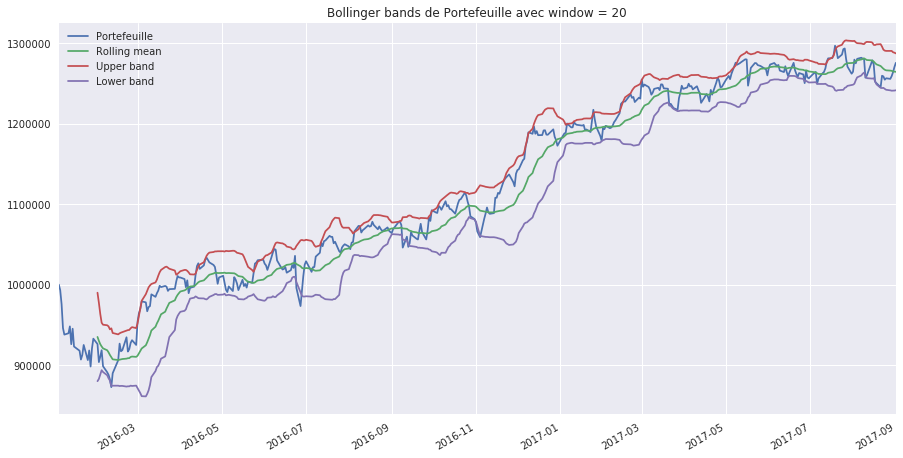

In [11]:
plot_bollinger_band(portfolio_value, "Portefeuille", window= 20)

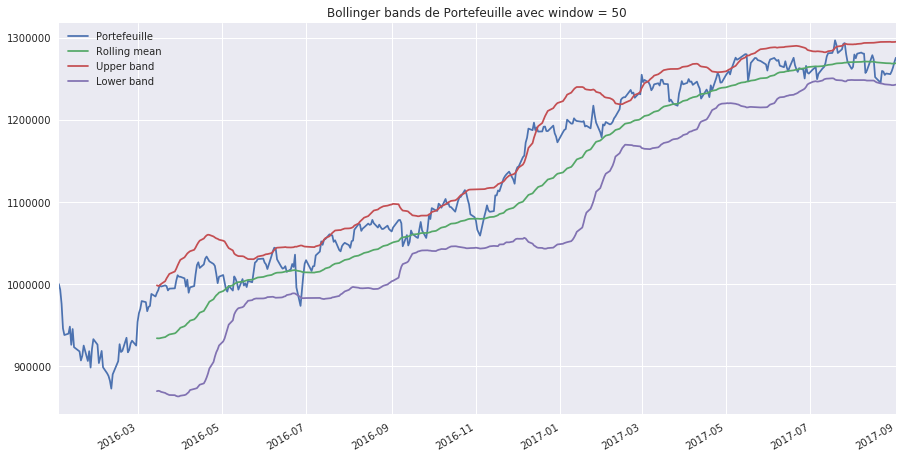

In [12]:
plot_bollinger_band(portfolio_value, "Portefeuille", window= 50)

## Optimize l'allocation du portefeuille

In [13]:
def error_optimal_allocations(allocations,symbols):
    portfolio_value = calculate_portforlio_value(start_value, start_date, end_date, symbols, allocations)
    avg_daily_return, std_daily_returns, beta, alpha, momentum, infor_ratio, sharpe_ratio = get_stocks_stas(portfolio_value, start_date, end_date)
    error = sharpe_ratio * -1 #because we want to maximize sharpe ratio
    return error

In [19]:
def find_optimal_allocations(prices):
    guess = 1.0/prices.shape[1]
    function_guess = [guess] * prices.shape[1]
    bounds = [[0,1] for _ in prices.columns]
    cons = ({ 'type': 'eq', 'fun': lambda function_guess: 1.0 - np.sum(function_guess) })
    result = spo.minimize(error_optimal_allocations, function_guess, args = (prices,), method='SLSQP', bounds = bounds, constraints = cons, options={'disp':True})
    allocs = result.x
    
    return allocs

In [20]:
data_frame = get_data_frame_for_symbols(list_stocks, start_date, end_date)
data_frame.drop("SPY", inplace = True, axis = 1)

In [21]:
optimal_allocations = find_optimal_allocations(data_frame)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2.074077207428049
            Iterations: 10
            Function evaluations: 163
            Gradient evaluations: 10


In [31]:
def optimize_portfolio(start_date, end_date, list_stocks):
    data_frame = get_data_frame_for_symbols(list_stocks, start_date, end_date)
    data_frame.drop("SPY", inplace = True, axis = 1)  # only portfolio symbols
    spy_value = spy_data_frame(start_date, end_date)

    # Get optimal allocations
    allocs = find_optimal_allocations(data_frame)
    allocs = allocs / np.sum(allocs)  # normalize allocations

    
    # Get portfolio statistics 
    avg_daily_return, std_daily_returns, beta, alpha, momentum, infor_ratio, sharpe_ratio = assess_portfolio(start_value, start_date, end_date, list_stocks , allocs)
    
    print([avg_daily_return, std_daily_returns, beta, alpha, momentum, infor_ratio, sharpe_ratio])
    
    #Get portfolio value
    portfolio_value = calculate_portforlio_value(start_value, start_date, end_date, list_stocks, allocs)
    
    portfolio_value_return = portfolio_value/portfolio_value[0]
    spy_value_return = spy_value/spy_value.ix[0]
    
    
    plt.figure(figsize=(12,6))
    plt.plot(portfolio_value_return, 'b', label = "Notre portefeuille")
    plt.plot(spy_value_return, 'r', label = 'SP500')
    plt.title("Portefeuille vs indice S&P500")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend(loc = 'upper left')
    
    plt.savefig('figure/performace_alloc')
    return portfolio_value

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2.074077207428049
            Iterations: 10
            Function evaluations: 163
            Gradient evaluations: 10
[0.0011889379200242156, 0.0090998562138751085, 0.60617207588905142, 0.00082803088627462357, 0.0094178147343253471, 1.0354369295762387, 2.074077207428048]


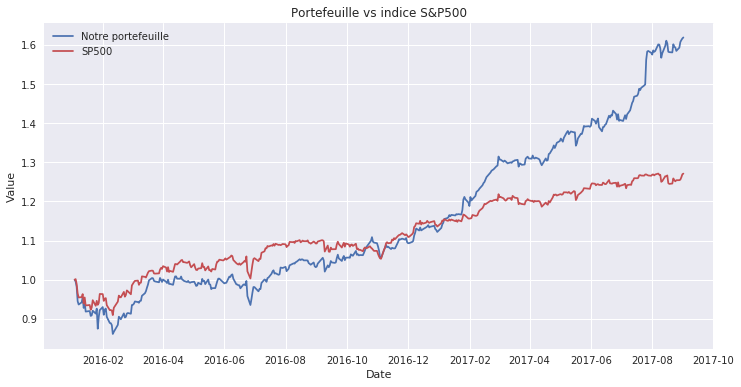

In [32]:
portfolio_value = optimize_portfolio(start_date, end_date, list_stocks)

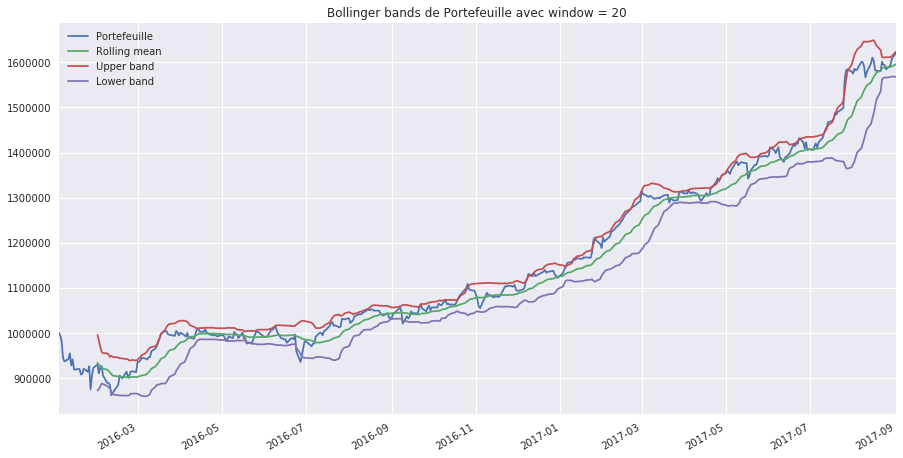

In [24]:
plot_bollinger_band(portfolio_value, "Portefeuille", window= 20)

In [25]:
allocs_porfolio = pd.DataFrame(list(optimal_allocations)).T * 100

In [26]:
allocs_porfolio.columns = list_stocks
allocs_porfolio.rename(index= {0 : "allocations"}, inplace= True)

In [27]:
allocs_porfolio

,AAPL,GOOG,AMZN,AXP,BAC,BA,KO,FB,IBM,GE,GS,HP,XOM,F
allocations,22.958991,0.0,2.951436,10.082894,0.0,37.689986,9.738894,16.577799,0.0,0.0,9.635847e-16,1.114939e-13,0.0,4.456749e-14


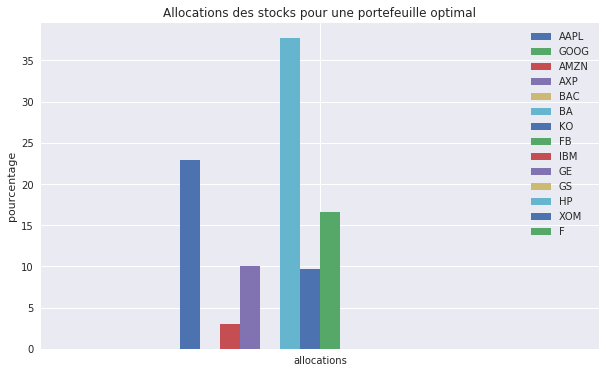

In [28]:
allocs_porfolio.plot(kind = 'bar', figsize= (10,6), rot= 0)
plt.ylabel("pourcentage")
plt.title("Allocations des stocks pour une portefeuille optimal")

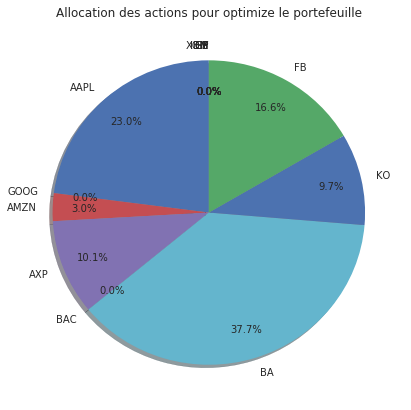

In [33]:
plt.figure(figsize= (7,7))
plt.pie(optimal_allocations, labels= list_stocks, autopct='%1.1f%%', pctdistance=0.8, shadow=True ,startangle=90)
plt.title("Allocation des actions pour optimize le portefeuille")
plt.savefig('figure/allocation')